In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import joblib
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format','{:.3f}'.format)
pd.set_option('display.max_columns',None)

In [3]:
churn_df = pd.read_csv('churn_cleaned1.csv')

In [4]:
churn_df.head()

,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,weekly_max_night_mins,videos_watched,customer_support_calls,churn
0,0,36,62,0,0,148.350,12.200,82,1,1,0
1,0,39,149,0,0,294.450,7.700,87,3,2,0
2,0,65,126,0,0,87.300,11.900,91,1,5,1
3,0,24,131,0,1,321.300,9.500,102,4,3,0
4,0,40,191,0,0,243.000,10.900,83,7,1,0


- Train Test Split

In [5]:
X = churn_df.drop(columns=['churn'])
y = churn_df['churn']

In [6]:
X.shape, y.shape

((2000, 10), (2000,))

- Check Class Imbalance problem is there or not

In [7]:
#churn_df['churn'].value_counts()
y.value_counts()

0    1738
1     262
Name: churn, dtype: int64

In [8]:
#churn_df['churn'].value_counts(normalize=True)
y.value_counts(normalize=True)

0   0.869
1   0.131
Name: churn, dtype: float64

In [9]:
1738/262

# This value is greater than 2 & no of records of minority class is less than 500
# So, we will apply SMOTE technique

6.633587786259542

In [10]:
# sampling_strategy = {
#     3: 50,  # Increase class 3 to 50 samples
#     8: 50,  # Increase class 8 to 50 samples
#     4: 55   # Increase class 4 to 55 samples
# }

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Apply the AMOTE object on training data
X_new, y_new = smote.fit_resample(X=X,y=y)

In [11]:
X_new.shape, y_new.shape

((3476, 10), (3476,))

In [12]:
y_new.value_counts()

0    1738
1    1738
Name: churn, dtype: int64

In [13]:
# from xgboost.sklearn import XGBClassifier
adb = AdaBoostClassifier(estimator=DecisionTreeClassifier(),random_state=42)

In [14]:
adb.get_params()

{'algorithm': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [15]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'estimator__max_depth': [6,7,8],  # Hyperparameters for the base estimator
    'estimator__min_samples_split': [5, 7, 10],
    'estimator__min_samples_leaf': [1,2,3],
}

In [16]:
grid_search = GridSearchCV(adb,param_grid=params,scoring='accuracy',cv=5,verbose=True)

In [17]:
grid_search

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=42),
             param_grid={'estimator__max_depth': [6, 7, 8],
                         'estimator__min_samples_leaf': [1, 2, 3],
                         'estimator__min_samples_split': [5, 7, 10],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new,test_size=0.25,random_state=43)

In [19]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                          random_state=42),
             param_grid={'estimator__max_depth': [6, 7, 8],
                         'estimator__min_samples_leaf': [1, 2, 3],
                         'estimator__min_samples_split': [5, 7, 10],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=True)

In [20]:
grid_search.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_split=10),
                   learning_rate=1, n_estimators=200, random_state=42)

In [21]:
grid_search.best_params_

{'estimator__max_depth': 8,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 10,
 'learning_rate': 1,
 'n_estimators': 200}

In [22]:
grid_search.best_score_

0.9259668630176275

In [23]:
grid_search.cv_results_

{'mean_fit_time': array([0.83402214, 1.61607814, 3.29397683, 0.82854004, 1.61650548,
        3.26229529, 0.81848636, 1.67770958, 3.18789043, 0.82910733,
        1.65877867, 3.26706991, 0.82946997, 1.67083225, 3.19242187,
        0.78529553, 1.56412263, 3.12275023, 0.80963678, 1.60674624,
        3.22729988, 0.81485834, 1.63903313, 3.20944672, 0.81650538,
        1.60811834, 3.24142203, 0.87030482, 1.77499366, 3.27513084,
        0.85073891, 1.63098521, 3.22892618, 0.87710404, 1.73003812,
        3.3004365 , 0.8099164 , 1.7262001 , 3.19176354, 0.80280576,
        1.57053161, 3.16016245, 0.8134181 , 1.6123044 , 3.3900332 ,
        0.86952386, 1.6467968 , 3.19039502, 0.7735076 , 1.62105188,
        3.68048687, 1.08013315, 2.1404798 , 4.23652449, 1.03469138,
        1.95414729, 3.22825351, 0.84026299, 1.66500459, 3.51089959,
        0.84417939, 1.655726  , 3.45373597, 0.8495831 , 1.6794991 ,
        3.50536089, 0.86211762, 1.5665256 , 3.43427906, 0.80089474,
        1.65911536, 3.25262599,

In [24]:
grid_search.feature_names_in_

array(['gender', 'age', 'no_of_days_subscribed', 'multi_screen',
       'mail_subscribed', 'weekly_mins_watched', 'minimum_daily_mins',
       'weekly_max_night_mins', 'videos_watched',
       'customer_support_calls'], dtype=object)

In [25]:
grid_search.score(X_train,y_train)

1.0

In [26]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__max_depth', 'param_estimator__min_samples_leaf', 'param_estimator__min_samples_split', 'param_learning_rate', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [27]:
len(grid_search.cv_results_['split0_test_score'])

324

In [28]:
c1 = grid_search.cv_results_['split0_test_score']
c2 = grid_search.cv_results_['split1_test_score']
c3 = grid_search.cv_results_['split2_test_score']
c4 = grid_search.cv_results_['split3_test_score']
c5 = grid_search.cv_results_['split4_test_score']

cv_df = pd.DataFrame(data = zip(c1,c2,c3,c4,c5),
                     index = grid_search.cv_results_['params'],
                     columns=['C1','C2','C3','C4','C5'])

cv_df

,C1,C2,C3,C4,C5
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 50}",0.776,0.784,0.781,0.777,0.774
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 100}",0.801,0.785,0.787,0.772,0.789
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 200}",0.814,0.784,0.802,0.783,0.808
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.1, 'n_estimators': 50}",0.818,0.812,0.810,0.800,0.810
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.1, 'n_estimators': 100}",0.805,0.810,0.806,0.810,0.823
...,...,...,...,...,...
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 0.5, 'n_estimators': 100}",0.912,0.906,0.906,0.931,0.896
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 0.5, 'n_estimators': 200}",0.925,0.912,0.914,0.940,0.912
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 1, 'n_estimators': 50}",0.912,0.902,0.893,0.904,0.891
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 1, 'n_estimators': 100}",0.920,0.920,0.900,0.929,0.912


In [29]:
avg = [i.sum()/5 for i in cv_df.values]
cv_df['Average'] = avg
cv_df

,C1,C2,C3,C4,C5,Average
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 50}",0.776,0.784,0.781,0.777,0.774,0.778
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 100}",0.801,0.785,0.787,0.772,0.789,0.787
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 200}",0.814,0.784,0.802,0.783,0.808,0.798
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.1, 'n_estimators': 50}",0.818,0.812,0.810,0.800,0.810,0.810
"{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.1, 'n_estimators': 100}",0.805,0.810,0.806,0.810,0.823,0.811
...,...,...,...,...,...,...
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 0.5, 'n_estimators': 100}",0.912,0.906,0.906,0.931,0.896,0.910
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 0.5, 'n_estimators': 200}",0.925,0.912,0.914,0.940,0.912,0.921
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 1, 'n_estimators': 50}",0.912,0.902,0.893,0.904,0.891,0.900
"{'estimator__max_depth': 8, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 10, 'learning_rate': 1, 'n_estimators': 100}",0.920,0.920,0.900,0.929,0.912,0.916


In [30]:
cv_df['Average'].max(), grid_search.best_score_

(0.9259668630176275, 0.9259668630176275)

In [31]:
cv_df['Average'].idxmax()

{'estimator__max_depth': 8,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 10,
 'learning_rate': 1,
 'n_estimators': 200}

In [32]:
grid_search.best_params_

{'estimator__max_depth': 8,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 10,
 'learning_rate': 1,
 'n_estimators': 200}

- Apply Cross Validation now as we know the best estimator & params now

In [33]:
accuracy_list=cross_val_score(grid_search.best_estimator_,
                              X_train,
                              y_train,
                              cv=5,
                              scoring='accuracy')
accuracy_list

# It will give each part accuracy
# by using best model (best estimator)

array([0.92528736, 0.93103448, 0.91554702, 0.92898273, 0.92898273])

In [34]:
np.mean(accuracy_list), grid_search.best_score_

(0.9259668630176275, 0.9259668630176275)

- Model Evaluation

In [35]:
best_model = grid_search.best_estimator_

In [36]:
ypred_train = best_model.predict(X_train)

In [37]:
ypred_test = best_model.predict(X_test)

In [38]:
train_acc = accuracy_score(y_train,ypred_train)
train_acc

1.0

In [39]:
test_acc = accuracy_score(y_test,ypred_test)
test_acc

0.9424626006904487

- that means our model is not overfit

In [40]:
print(classification_report(y_test,ypred_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       429
           1       0.94      0.95      0.94       440

    accuracy                           0.94       869
   macro avg       0.94      0.94      0.94       869
weighted avg       0.94      0.94      0.94       869



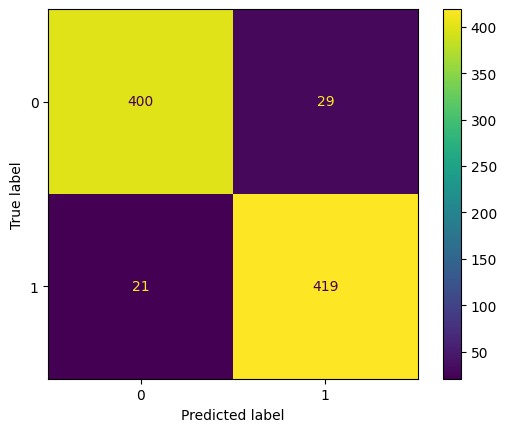

In [41]:
cmt = confusion_matrix(y_test,ypred_test)
disp = ConfusionMatrixDisplay(cmt,display_labels=best_model.classes_)
disp.plot()
plt.show()

In [42]:
tn, fp, fn, tp = confusion_matrix(y_test,ypred_test).ravel()
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

True Negative: 400
False Positive: 29
False Negative: 21
True Positive: 419


In [43]:
ypred_test_prob = best_model.predict_proba(X_test)
ypred_test_prob

array([[0.64392213, 0.35607787],
       [0.62184415, 0.37815585],
       [0.67042642, 0.32957358],
       ...,
       [0.3232806 , 0.6767194 ],
       [0.39209829, 0.60790171],
       [0.75838433, 0.24161567]])

In [44]:
ypred_test_prob[:,1]  # Class 1 probabilities

array([0.35607787, 0.37815585, 0.32957358, 0.40731971, 0.41554854,
       0.36065328, 0.70432898, 0.36872861, 0.68956141, 0.70323707,
       0.60469897, 0.60087906, 0.60821421, 0.260438  , 0.67287516,
       0.34588144, 0.69277495, 0.2750702 , 0.67820871, 0.28891416,
       0.57313741, 0.71215933, 0.35727927, 0.71172456, 0.31982277,
       0.2100822 , 0.69292646, 0.3096642 , 0.43066682, 0.58883594,
       0.72124027, 0.60362133, 0.26236382, 0.69568113, 0.63385738,
       0.70810589, 0.43885652, 0.53211934, 0.61627214, 0.5044174 ,
       0.67992103, 0.22277272, 0.66420384, 0.22474378, 0.47774185,
       0.7046448 , 0.66909296, 0.69238946, 0.33731254, 0.36331855,
       0.6520154 , 0.71204971, 0.65245393, 0.66187106, 0.68053107,
       0.68857922, 0.49200865, 0.60740991, 0.65343087, 0.71674341,
       0.56057747, 0.55608786, 0.32019465, 0.36226889, 0.35713263,
       0.33599141, 0.67635645, 0.505658  , 0.68966047, 0.63990592,
       0.68744937, 0.71353106, 0.70520823, 0.3638857 , 0.28282

In [45]:
fpr, tpr, thresholds = roc_curve(y_test,ypred_test_prob[:,1])

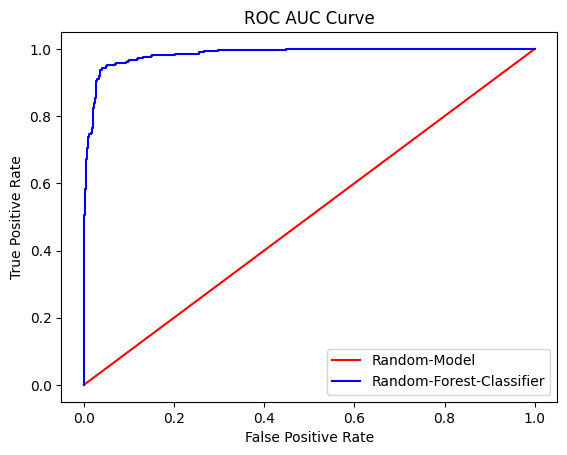

Area under the curve: 0.9846736596736598


In [46]:
plt.plot([0,1],[0,1],color='red',label='Random-Model')
plt.plot(fpr,tpr,color='blue',label='Random-Forest-Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()
print(f"Area under the curve: {auc(fpr,tpr)}")


- Feature Importance

In [47]:
best_model.feature_importances_

array([0.0211398 , 0.11219323, 0.1717312 , 0.01366163, 0.02012948,
       0.23464404, 0.16275609, 0.13224368, 0.06614985, 0.065351  ])

In [48]:
feature_importance = pd.DataFrame()

In [49]:
feature_importance['Features'] = X_train.columns

In [50]:
feature_importance['Importance'] = best_model.feature_importances_

In [51]:
feature_importance.sort_values(by='Importance',ascending=False)

,Features,Importance
5,weekly_mins_watched,0.235
2,no_of_days_subscribed,0.172
6,minimum_daily_mins,0.163
7,weekly_max_night_mins,0.132
1,age,0.112
8,videos_watched,0.066
9,customer_support_calls,0.065
0,gender,0.021
4,mail_subscribed,0.020
3,multi_screen,0.014


- Save the model

In [52]:
joblib.dump(best_model,'AdaBoost_Classifier.joblib')

['AdaBoost_Classifier.joblib']